## Imports

In [46]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

## Global Values

In [32]:
NUMBER_TORNADOS = 111 #Number of Tornado Events
NUMBER_RANDOM = 110 #Number of Random Events
NUMBER_DAYS = 14 #Number of days of data per Tornado/Event (Max: 57)
FILE_NAME = "all_weather.csv" #CSV file that contains the data

## Loading Data

In [33]:

#Field 0: 'datatime'
#Field 1: 'temperature'
#Field 2: 'windspeed'
#Field 3: 'surface solar radiation' -Alvaro
#Field 4: 'relative humidity' -Abdullah
#Field 5: 'surface pressure' -Frazier
#Field 6: 'total precipitation' -Simon
#Field 7: 'city'
#Field 8: 'event_id'
#Field 9: 'latitude'
#Field 10: 'longitude'
#Field 11: 'outcome'

data = pd.read_csv (FILE_NAME)
df = data.drop(columns=['Unnamed: 0'])
event_ids = set(df['event_id'].to_numpy())

## Create Timeserie Fetaures

In [34]:
# Determine slope of each weather attribute over time for each Tornado/Event
temp_change = []
wind_change = []
rain_change = []
radiation_change = []
pressure_change = []
humidity_change = []
x = list(range(NUMBER_DAYS))

for i in event_ids:
    event = df.loc[df['event_id'] == i]
    temp = event['temperature']
    wind = event['wind_speed']
    radiation = event['surface_solar_radiation']
    humidity = event['relative_humidity']
    pressure = event['surface_pressure']
    rain = event['total_precipitation']

    t_slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp.tail(NUMBER_DAYS))
    w_slope, intercept, r_value, p_value, std_err = stats.linregress(x, wind.tail(NUMBER_DAYS))
    r_slope, intercept, r_value, p_value, std_err = stats.linregress(x, rain.tail(NUMBER_DAYS))
    rd_slope, intercept, r_value, p_value, std_err = stats.linregress(x, radiation.tail(NUMBER_DAYS))
    p_slope, intercept, r_value, p_value, std_err = stats.linregress(x, pressure.tail(NUMBER_DAYS))
    h_slope, intercept, r_value, p_value, std_err = stats.linregress(x, humidity.tail(NUMBER_DAYS))

    temp_change.append(t_slope)
    wind_change.append(w_slope)
    rain_change.append(r_slope)
    radiation_change.append(rd_slope)
    pressure_change.append(p_slope)
    humidity_change.append(h_slope)


## Dataframe with mean values of each Tornado/Event

In [35]:
averages = df.groupby('event_id').tail(NUMBER_DAYS+7)
averages = averages.groupby('event_id').mean()

## Add Slope Features

In [36]:
averages['t_slope'] = temp_change
averages['w_slope'] = wind_change
averages['r_slope'] = rain_change
averages['rd_slope'] = radiation_change
averages['p_slope'] = pressure_change
averages['h_slope'] = humidity_change

## Model Prep

In [37]:
X = averages[['temperature','wind_speed','surface_solar_radiation','relative_humidity', 'total_precipitation', 't_slope', 'w_slope', 'r_slope', 'rd_slope', 'p_slope', 'h_slope']]
y = averages['outcome']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train Model with Logistic Regression

In [38]:
logisticRegr = LogisticRegression(max_iter=10000)
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)
print("Model Accuracy: ",score)

Model Accuracy:  0.8888888888888888


In [39]:
print("regression coefficients: \n", logisticRegr.coef_)


regression coefficients: 
 [[ 0.07529001  0.62336569  0.00274314 -0.00452992  2.54417718  1.16982022
   1.54257202  1.29218123 -0.06951692 -0.00859638  0.13963608]]


## Determine Individual Feature Strength

In [40]:
# Returns array with model accuracy based on individial feature
scores = []
for i in range(11):

    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_train.to_numpy()[:,i].reshape(-1,1), y_train)
    score = logisticRegr.score(x_test.to_numpy()[:,i].reshape(-1,1), y_test)
    scores.append(round(score,2))
print(scores)

[0.71, 0.49, 0.69, 0.62, 0.84, 0.87, 0.78, 0.87, 0.69, 0.82, 0.49]


## Train Model with Naive Bayes 

In [41]:

gnb = GaussianNB()
gnb.fit(x_train, y_train)
predictions = gnb.predict(x_test)
score = gnb.score(x_test, y_test)
print("Model Accuracy: ",score)

Model Accuracy:  0.9333333333333333


In [23]:
print(gnb.sigma_[]0)

[[8.89397788e+01 4.39834756e-01 5.80907358e+03 7.86109843e-03
  8.88425051e-03 3.73027297e-01 1.36670694e-02 1.29550693e-03
  2.53871373e+01 6.40711167e+03 1.42804503e-04]
 [2.32776971e+01 4.05691891e-01 2.64990153e+03 3.11938083e-03
  4.24502792e-02 1.11400590e-01 1.19163140e-02 8.21004687e-03
  1.83613910e+01 2.19813686e+03 8.08731477e-05]]


In [26]:
print(len(gnb.sigma_))

2


In [43]:
for i in range(len(gnb.sigma_)):
    for j in range(len(gnb.sigma_[i])):
        print(gnb.sigma_[i][j])

88.93977877822695
0.43983475587052684
5809.073576605323
0.007861098432037347
0.008884250512264344
0.3730272973982706
0.013667069426648375
0.001295506931850492
25.38713725995819
6407.111668114207
0.00014280450293539045
23.27769709264868
0.40569189059815575
2649.9015342411235
0.0031193808283513074
0.04245027923240426
0.1114005901394432
0.01191631399853169
0.00821004686758741
18.361391006753966
2198.136860388076
8.087314765006399e-05


In [25]:
print(len(gnb.sigma_[0]))
print(len(gnb.sigma_[1]))

11
11


In [14]:
scores = []
for i in range(11):

    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    predictions = gnb.predict(x_test)
    score = gnb.score(x_test, y_test)
    scores.append(round(score,2))

print(scores)

[0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93]


## Train Model with Decision Trees

In [45]:
DTC_model = tree.DecisionTreeClassifier()
DTC_model.fit(x_train, y_train)
predictions = DTC_model.predict(x_test)
score = DTC_model.score(x_test, y_test)
print("Model Accuracy: ",score)

Model Accuracy:  0.9111111111111111


## Train Model with KNN

In [55]:
    list_n =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20]
    scores = []
    for i in list_n:
        KNN_model = KNeighborsClassifier(n_neighbors= i )
        KNN_model.fit(x_train, y_train)
        predictions = KNN_model.predict(x_test)
        score = KNN_model.score(x_test, y_test)
        scores.append(score)
        print("Testing k = " + str(i))
        print("Model Accuracy: ",score)
        print()

Testing k = 1
Model Accuracy:  0.6666666666666666

Testing k = 2
Model Accuracy:  0.6666666666666666

Testing k = 3
Model Accuracy:  0.8444444444444444

Testing k = 4
Model Accuracy:  0.8222222222222222

Testing k = 5
Model Accuracy:  0.8666666666666667

Testing k = 6
Model Accuracy:  0.8

Testing k = 7
Model Accuracy:  0.7777777777777778

Testing k = 8
Model Accuracy:  0.7777777777777778

Testing k = 9
Model Accuracy:  0.7777777777777778

Testing k = 10
Model Accuracy:  0.7777777777777778

Testing k = 11
Model Accuracy:  0.7777777777777778

Testing k = 12
Model Accuracy:  0.7777777777777778

Testing k = 13
Model Accuracy:  0.7777777777777778

Testing k = 14
Model Accuracy:  0.7777777777777778

Testing k = 15
Model Accuracy:  0.7555555555555555

Testing k = 16
Model Accuracy:  0.7555555555555555

Testing k = 17
Model Accuracy:  0.7777777777777778

Testing k = 19
Model Accuracy:  0.7555555555555555

Testing k = 20
Model Accuracy:  0.7555555555555555



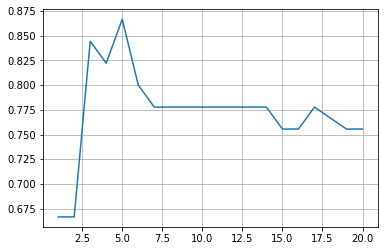

In [58]:
    plt.plot(list_n, scores)
    plt.grid()

Model Accuracy:  0.8666666666666667
